In [ ]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 6.44,
    "longitude": 2.339997,
    "start_date": "2018-01-01",
    "end_date": "2026-01-01",
    "hourly": [
        "relative_humidity_2m",
        "temperature_2m",
        "apparent_temperature",
        "precipitation",
        "wind_speed_10m",
        "surface_pressure",
    ],
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

Coordinates: 6.432337284088135°N 2.338641881942749°E
Elevation: 20.0 m asl
Timezone difference to GMT+0: 0s


In [6]:
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_temperature_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(4).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(5).ValuesAsNumpy()

hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left",
    )
}

hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["surface_pressure"] = hourly_surface_pressure

hourly_dataframe = pd.DataFrame(data=hourly_data)
print("\nHourly data\n", hourly_dataframe.head(10))


Hourly data
                        date  relative_humidity_2m  temperature_2m  \
0 2018-01-01 00:00:00+00:00             97.609978       23.299999   
1 2018-01-01 01:00:00+00:00             97.895798       22.650000   
2 2018-01-01 02:00:00+00:00             97.308746       23.000000   
3 2018-01-01 03:00:00+00:00             96.710915       22.650000   
4 2018-01-01 04:00:00+00:00             96.708481       22.549999   
5 2018-01-01 05:00:00+00:00             96.403358       22.150000   
6 2018-01-01 06:00:00+00:00             96.097267       21.750000   
7 2018-01-01 07:00:00+00:00             92.370407       22.500000   
8 2018-01-01 08:00:00+00:00             83.868896       24.150000   
9 2018-01-01 09:00:00+00:00             69.397995       26.350000   

   apparent_temperature  precipitation  wind_speed_10m  surface_pressure  
0             27.898342            0.0        5.771239       1009.670776  
1             27.103289            0.0        4.394360       1008.967285  
2

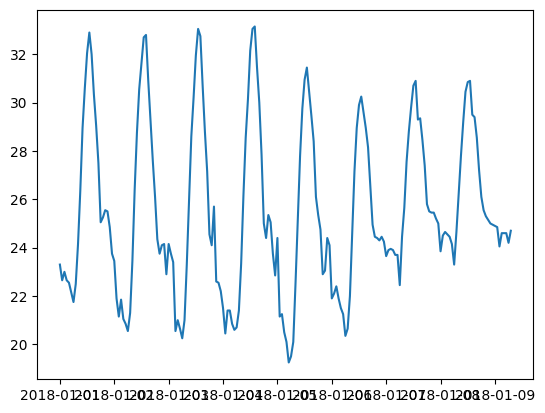

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(hourly_data["date"][:200], hourly_data["temperature_2m"][:200])

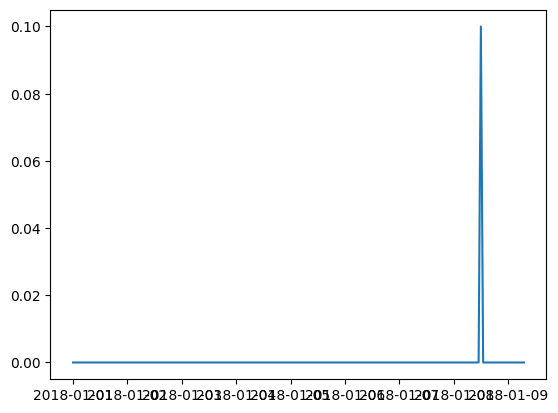

In [12]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(hourly_data["date"][:200], hourly_data["precipitation"][:200])